## Fit a kernel to the pulsation only signal, measure accuracy

- Use GPyTorch
- Pulsation + noise
- RBF kernel

In [1]:
import os
import sys
import math
import torch
import gpytorch
%load_ext autoreload
%autoreload 2

import numpy as np
# Plotting tools
from matplotlib import pyplot as plt
# we use the following for plotting figures in jupyter
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from astropy.timeseries import LombScargle
import pandas as pd
pd.set_option('precision', 0)
pd.set_option('display.float_format', lambda x: '%.16f' % x)

# Start the notebook from the root of the project
if 'notebooks' in os.getcwd():
    os.chdir(os.path.dirname(os.getcwd()))
    if os.getcwd().endswith('notebooks'):
        os.chdir(os.path.dirname(os.getcwd()))

 # Local imports (i.e., my code) from the src folder
sys.path.insert(0, os.path.join(os.getcwd(), 'src'))

from plot_helpers import *
plotter = PlotUtilGPyTorch()

Read the first time series

In [2]:
USE_CUDA = False
#if torch.cuda.device_count() > 0:
#    torch.cuda.set_device(0)
#    print("USE GPU")

In [3]:
# Make the notebook use the whole screen width
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

In [4]:
df = pd.read_csv("./data/sim_pulse.lc",sep=' ', header = None, names=['Time', 'Lc'], index_col=False, float_precision='round_trip')
df.dtypes

Time    float64
Lc      float64
dtype: object

In [5]:
X, Y = df['Time'].tolist(), df['Lc'].tolist()
X, Y = np.array(X), np.array(Y)

# 1. Exploratory
Plot the data

Zoomed in on the first N observations

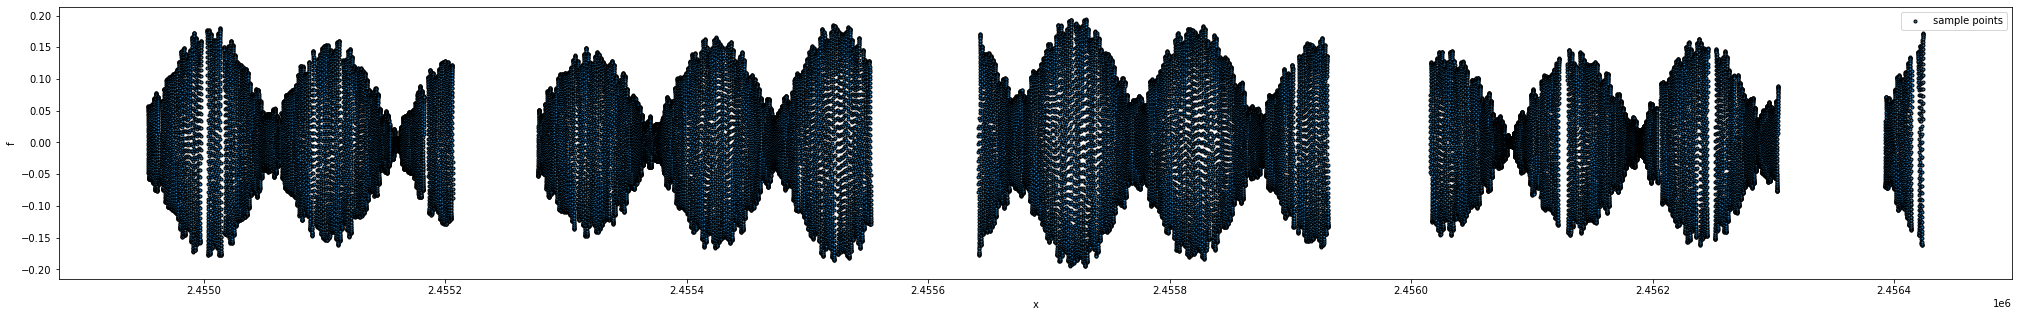

In [6]:
plotter.plot_data(X, Y)

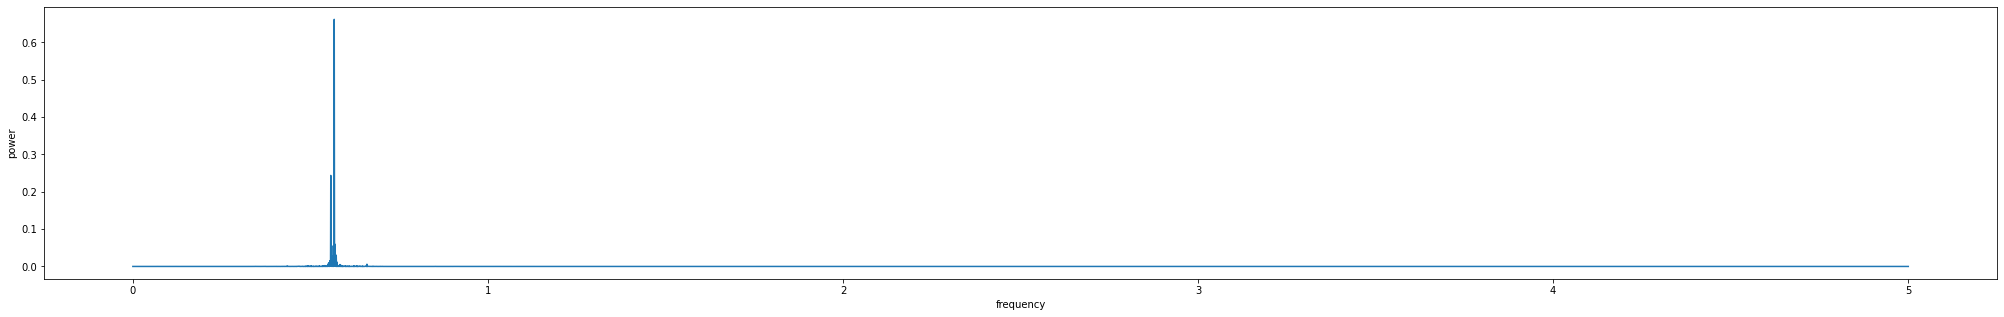

In [7]:
frequencies, power = plotter.plot_lomb_scargle_periodogram(X, Y, 0.0, 5)

In [8]:
N_part=11300

In [9]:
X_part=X[:N_part]
Y_part=Y[:N_part]

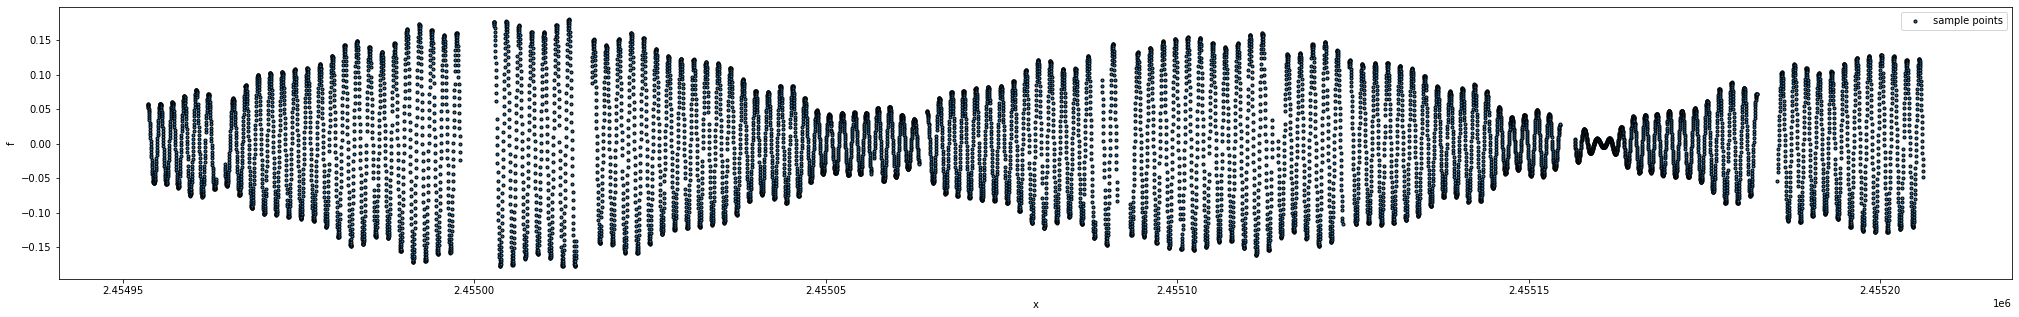

In [10]:
plotter.plot_data(X_part, Y_part)

# 2. Processing


Fit a simple smoothing kernel to the signal

In [11]:
# normalize the data
mean, std = Y_part.mean(),Y_part.std()
Y_part = (Y_part - mean) / std

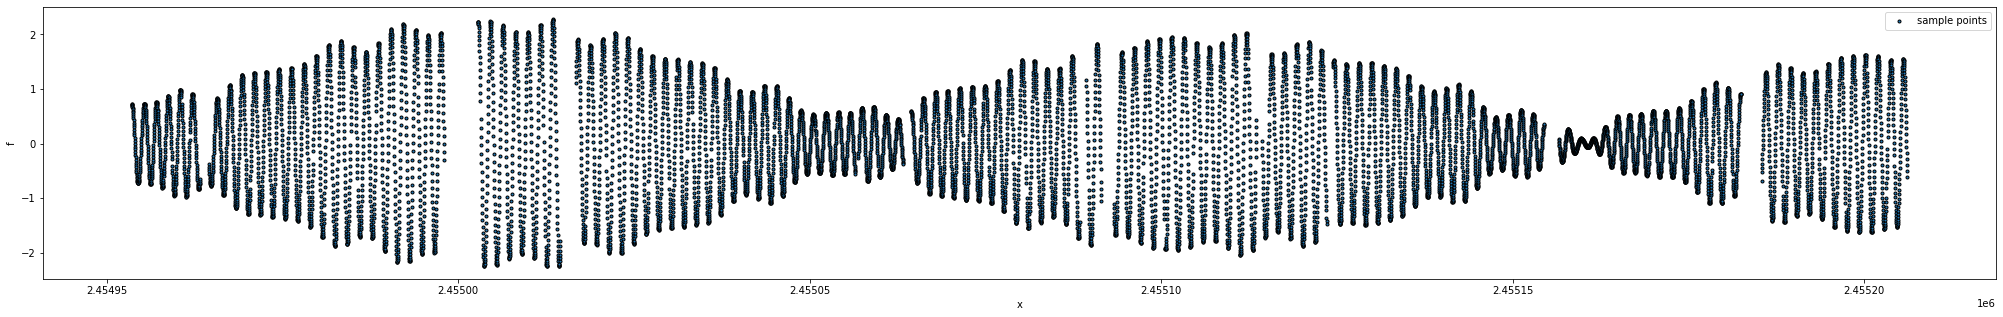

In [12]:
plotter.plot_data(X_part, Y_part)

In [13]:
X_part=torch.tensor(X_part)
Y_part=torch.tensor(Y_part)

Move data and models to the GPU

In [14]:
# Predict evenly spaced points on our time-axis
X_part_smooth = torch.tensor(np.linspace(X_part.min(), X_part.max(), N_part))

In [15]:
if USE_CUDA:
    X_part = X_part.cuda()
    Y_part = Y_part.cuda()
    model = model.cuda()
    likelihood = likelihood.cuda()

In [16]:
from gpytorch.priors import NormalPrior

# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        # Periodic kernel for the Pulsations
        self.pulse_kernel = gpytorch.kernels.PeriodicKernel()
        self.pulse_kernel.period_length = 1.77
        self.pulse_kernel.lengthscale = 0.001
        # Periodic kernel for the Gaps
        self.pulse_kernel2 = gpytorch.kernels.PeriodicKernel()
        self.pulse_kernel2.period_length = 1.77 * 3
        self.pulse_kernel2.lengthscale = 0.001
        # RBF kernel for the uncorrelated noise
        self.noise_kernel = gpytorch.kernels.RBFKernel()
        
        # No solution yet for the non-stationary instrumentation noise
        self.covar_module = gpytorch.kernels.AdditiveKernel(
            gpytorch.kernels.ScaleKernel(self.pulse_kernel),
            gpytorch.kernels.ScaleKernel(self.pulse_kernel2),
            gpytorch.kernels.ScaleKernel(self.noise_kernel),
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(X_part, Y_part, likelihood)

# As we are using float64 data, we need to convert our model to double
_ = model.double()
_ = likelihood.double()

In [17]:
training_iter = 50

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer on a subset of the hyperparameters
all_params = set(model.parameters())
final_params = list(all_params - {model.covar_module.kernels[0].base_kernel.raw_period_length})
optimizer = torch.optim.Adam(final_params, lr=0.15)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(X_part)
    # Calc loss and backprop gradients
    loss = -mll(output, Y_part)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   Period length: %.3f    noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.kernels[0].base_kernel.period_length.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/50 - Loss: 0.942   Period length: 1.770    noise: 0.693
Iter 2/50 - Loss: 0.860   Period length: 1.770    noise: 0.621
Iter 3/50 - Loss: 0.786   Period length: 1.770    noise: 0.554
Iter 4/50 - Loss: 0.717   Period length: 1.770    noise: 0.493
Iter 5/50 - Loss: 0.655   Period length: 1.770    noise: 0.437
Iter 6/50 - Loss: 0.597   Period length: 1.770    noise: 0.386
Iter 7/50 - Loss: 0.538   Period length: 1.770    noise: 0.340
Iter 8/50 - Loss: 0.472   Period length: 1.770    noise: 0.299
Iter 9/50 - Loss: 0.412   Period length: 1.770    noise: 0.262
Iter 10/50 - Loss: 0.348   Period length: 1.770    noise: 0.229
Iter 11/50 - Loss: 0.281   Period length: 1.770    noise: 0.199
Iter 12/50 - Loss: 0.213   Period length: 1.770    noise: 0.173
Iter 13/50 - Loss: 0.147   Period length: 1.770    noise: 0.150
Iter 14/50 - Loss: 0.077   Period length: 1.770    noise: 0.130
Iter 15/50 - Loss: 0.004   Period length: 1.770    noise: 0.113
Iter 16/50 - Loss: -0.073   Period length: 1.770 

In [18]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [19]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    Y_part_pred = likelihood(model(X_part))

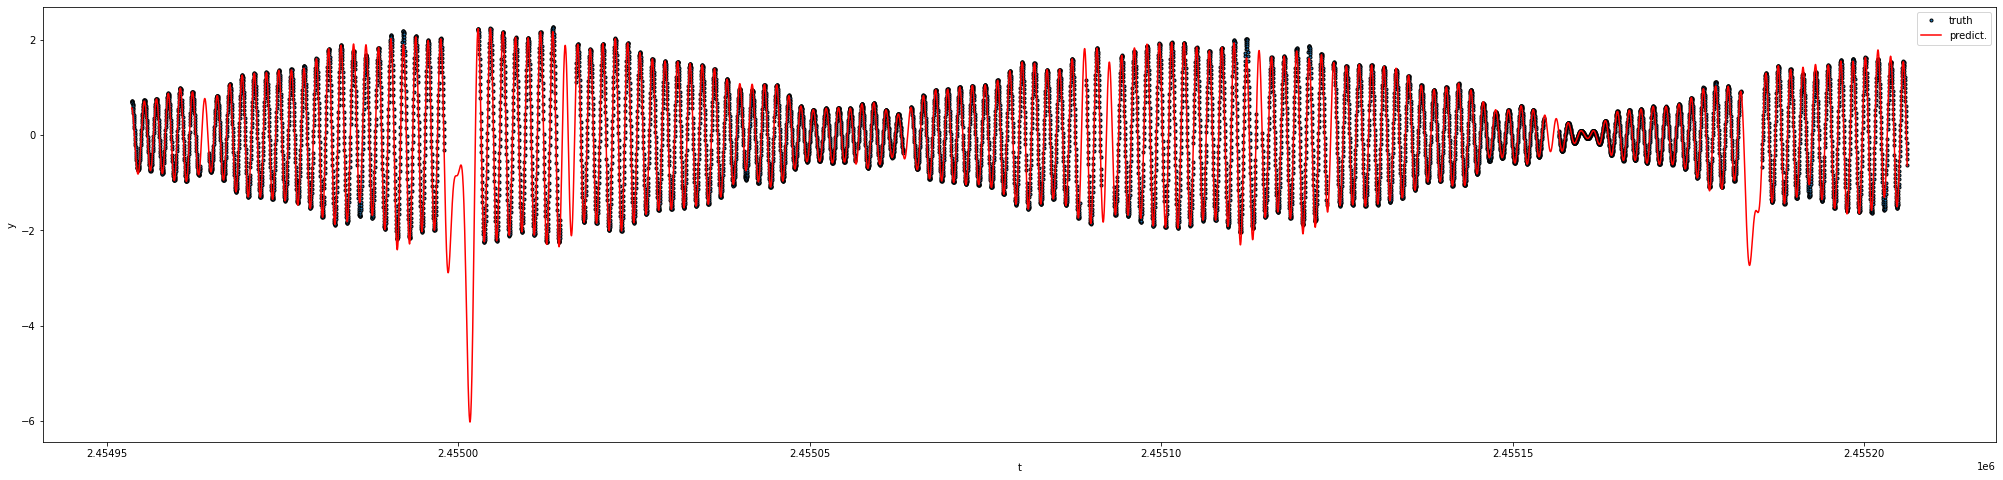

In [20]:
# Test points are regularly spaced along train_x
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(X_part_smooth))
    
with torch.no_grad():
    plotter.plot_series(X_part.cpu().numpy(), Y_part.cpu().numpy(), X_part_smooth.cpu().numpy(), observed_pred.mean.cpu().numpy())

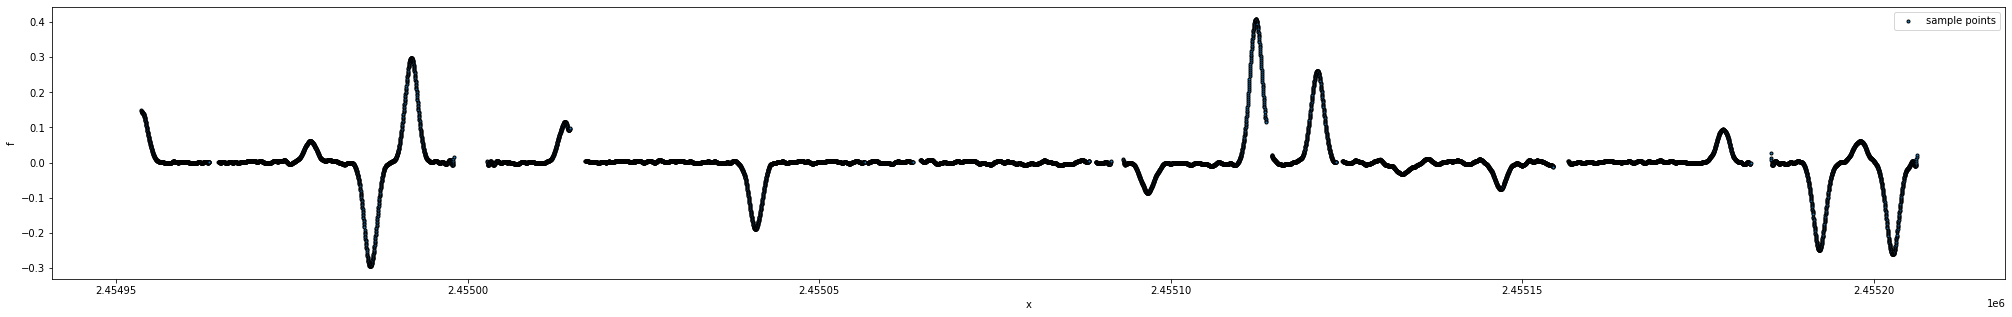

In [21]:
# Calculate the residuals on the original X positions!
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    residuals = Y_part.cpu()-Y_part_pred.mean.cpu().numpy()
    plotter.plot_data(X_part.cpu(), residuals)

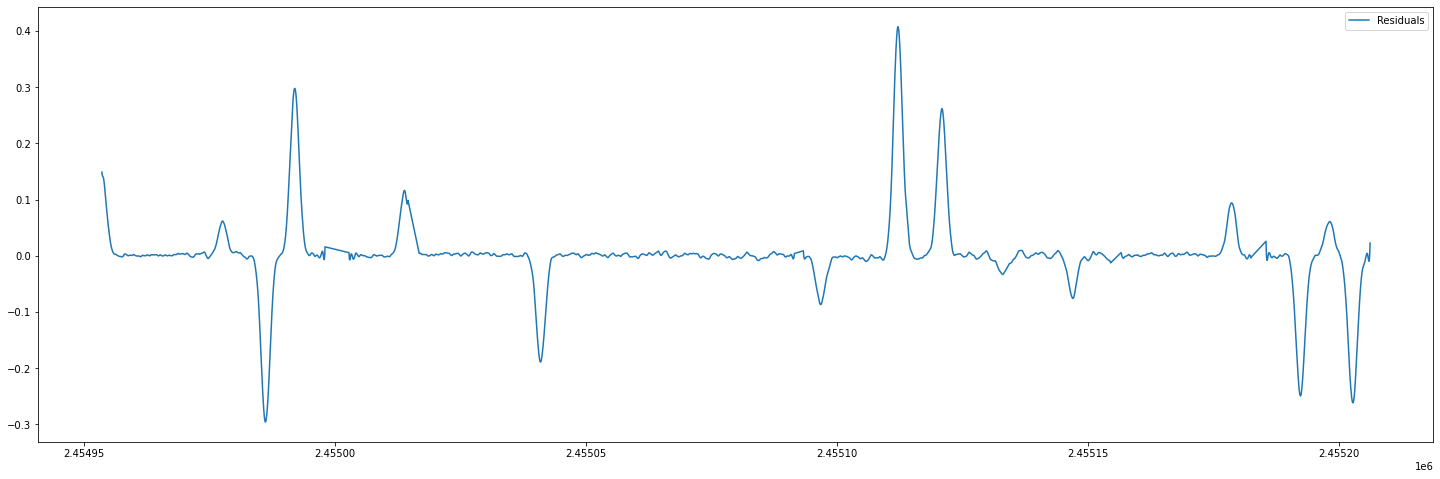

In [22]:
# Plot GP residuals
plt.figure(figsize=(25, 8))
plt.plot(X_part.cpu(), residuals, "-")
plt.legend(labels=["Residuals"])

### RMSE

In [23]:
np.sqrt(np.nanmean((Y_part_pred.mean.cpu().numpy()-Y_part.cpu().numpy())**2))

0.06483348266649175

In [24]:
print(model.covar_module.base_kernel.lengthscale.item())

AttributeError: 'AdditiveKernel' object has no attribute 'base_kernel'

# Correlation between the original data and the fitted data

In [ ]:
ts_orig = pd.DataFrame()
ts_orig['signal'] = Y_part.cpu().numpy()
ts_fitted = pd.DataFrame()
ts_fitted['signal'] = Y_part_pred.mean.cpu().numpy()

In [ ]:
ts_orig.corrwith(ts_fitted)

In [ ]:
# Trial 1: 0.9996141312510112 correlation, 50 iterations, length scale: 0.8564778816833526
# Trial 2: 0.9996349929097408 correlation, 100 iterations, length scale: 0.9996349929097408

# Conclusion:
#    100 iterations results in a slightly higher correlation. Note: depends on random initialization, I have seen 0.999631 too for 50 iterations.
#    TODO: Compare two timeseries visually, my guess is that on the one with 50 iterations does not reach the crests and throughs of the sine waves.